<a href="https://colab.research.google.com/github/alexeiplatzer/unitree-go2-mjx-rl/blob/main/notebooks/Universal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Univeral Notebook for Quadruped RL Training in MJX**
This notebook uses the `quadruped-mjx-rl` python package from the `unitree-go2-mjx-rl` repository to train locomotion policies for quadrupeds using reinforcement learning in the Mujoco XLA (MJX) simulation environment.

# Hardware Setup
This part sets up the `quadruped-mjx-rl` package on the machine.

In [1]:
#@title run this cell once each time on a new machine
#@markdown #### Setup configuration

#@markdown Choose your hardware option:
hardware = "Colab" #@param ["local","Colab","Kaggle"]

#@markdown Choose whether you want to build the madrona rendering setup for training
#@markdown with vision:
build_madrona_backend = False #@param {"type":"boolean"}

#@markdown Choose if you want to pull changes to the package repository during the runtime.
#@markdown (Requires a restart after executing this cell!)
editable_mode = True #@param {"type":"boolean"}

if build_madrona_backend:
    # Install madrona MJX
    import time
    print("Intalling Madrona MJX...")
    start_time = time.perf_counter()
    print("Setting up environment... (Step 1/3)")
    !pip uninstall -y jax
    !pip install jax["cuda12_local"]==0.4.35

    !sudo apt install libx11-dev libxrandr-dev libxinerama-dev libxcursor-dev libxi-dev mesa-common-dev

    !mkdir modules
    !git clone https://github.com/shacklettbp/madrona_mjx.git modules/madrona_mjx

    !git -C modules/madrona_mjx submodule update --init --recursive

    !mkdir modules/madrona_mjx/build

    if hardware == "Kaggle":
        !sudo apt-get install -y nvidia-cuda-toolkit

    print("Building the Madrona backend ... (Step 2/3)")
    !cd modules/madrona_mjx/build && cmake -DLOAD_VULKAN=OFF .. && make -j 8

    print ("Installing Madrona MJX ... (Step 3/3)")
    !pip install -e modules/madrona_mjx

    minutes, seconds = divmod((time.perf_counter() - start_time), 60)
    print(f"Finished installing Madrona MJX in {minutes} m {seconds:.2f} s")

# Clones and installs our Quadruped RL package
!git clone https://github.com/alexeiplatzer/unitree-go2-mjx-rl.git
if editable_mode:
    !pip install -e unitree-go2-mjx-rl
else:
    !pip install unitree-go2-mjx-rl

Cloning into 'unitree-go2-mjx-rl'...
remote: Enumerating objects: 1746, done.
remote: Counting objects: 100% (166/166), done.
remote: Compressing objects: 100% (102/102), done.
remote: Total 1746 (delta 73), reused 113 (delta 58), pack-reused 1580 (from 1)
Receiving objects: 100% (1746/1746), 23.12 MiB | 16.38 MiB/s, done.
Resolving deltas: 100% (989/989), done.
Obtaining file:///content/unitree-go2-mjx-rl
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.7/341.7 kB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 103.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━

### Now restart the session and continue.
### You can skip setup next time while you are on the same machine.

# Session setup
Run once in the beggining of every session, i.e. after restarts and crashes.

In [6]:
# @title Refresh the package if any necessary changes have been pushed. Important in development
repo_path = "./unitree-go2-mjx-rl"
!git -C {repo_path} pull

remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 6 (delta 3), reused 6 (delta 3), pack-reused 0 (from 0)
Unpacking objects: 100% (6/6), 620 bytes | 620.00 KiB/s, done.
From https://github.com/alexeiplatzer/unitree-go2-mjx-rl
   f458c4d..5fbd72d  main       -> origin/main
Updating f458c4d..5fbd72d
Fast-forward
 configs/google_barkour_vb.yaml                     |    2 +-
 configs/raw_ppo.yaml                               |    4 +-
 configs/render_basic.yaml                          |    3 +-
 configs/unitree_go2.yaml                           |    2 +-
 configs/vision_ppo.yaml                            |    1 -
 notebooks/Prototypes/Madroner.ipynb                | 2836 ++++++++++----------
 notebooks/Universal.ipynb                          |    4 +-
 pyproject.toml                                     |   15 +-
 requirements.txt                                   |   16 +-
 scripts/config_writ

In [1]:
# @title Configuration for both local and for Colab instances.

import os
# On your second reading, load the compiled rendering backend to save time!
# os.environ["MADRONA_MWGPU_KERNEL_CACHE"] = "modules/madrona_mjx/build/cache"
# Ensure that Madrona gets the chance to pre-allocate memory before Jax
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

# Check if MuJoCo installation was successful
import distutils.util
import subprocess
if subprocess.run('nvidia-smi').returncode:
    raise RuntimeError(
        'Cannot communicate with GPU. '
        'Make sure you are using a GPU Colab runtime. '
        'Go to the Runtime menu and select Choose runtime type.'
    )

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
    with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
        f.write("""{
        "file_format_version" : "1.0.0",
        "ICD" : {
            "library_path" : "libEGL_nvidia.so.0"
        }
    }
    """)

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

try:
    print('Checking that the installation succeeded:')
    import mujoco

    mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
    raise e from RuntimeError(
        'Something went wrong during installation. Check the shell output above '
        'for more information.\n'
        'If using a hosted Colab runtime, make sure you enable GPU acceleration '
        'by going to the Runtime menu and selecting "Choose runtime type".'
    )

print('Installation successful.')

# Tell XLA to use Triton GEMM, this improves steps/sec by ~30% on some GPUs
xla_flags = os.environ.get('XLA_FLAGS', '')
xla_flags += ' --xla_gpu_triton_gemm_any=True'
os.environ['XLA_FLAGS'] = xla_flags

# More legible printing from numpy.
import numpy as np
np.set_printoptions(precision=3, suppress=True, linewidth=100)

# Prepare directories
from etils.epath import Path
repo_path = Path("unitree-go2-mjx-rl")
experiments_dir = Path("experiments")
trained_policy_dir = experiments_dir / "trained_policies"
!mkdir -p {trained_policy_dir}
configs_dir = experiments_dir / "configs"
!mkdir -p {configs_dir}
rollout_configs_dir = configs_dir / "rollout_configs"
!mkdir -p {rollout_configs_dir}
animations_dir = experiments_dir / "rendered_rollouts"
!mkdir -p {animations_dir}

Setting environment variable to use GPU rendering:
env: MUJOCO_GL=egl
Checking that the installation succeeded:
Installation successful.


# Training

## Configurations

### Robot Configuration

In [2]:
from quadruped_mjx_rl.robots import predefined_robot_configs
#@markdown #### Choose the robot
robot = "unitree_go2" #@param ["unitree_go2", "google_barkour_vb"]
robot_config = predefined_robot_configs[robot]()

### Model Configuration

In [3]:
# @title #### Choose the model architecture and set its hyperparameters
from quadruped_mjx_rl import models
model_architecture = "ActorCritic" # @param ["ActorCritic","TeacherStudent","TeacherStudentVision"]
# @markdown ---
# @markdown **Model hyperparameters for the Actor-Critic Architecture**
if model_architecture == "ActorCritic":
    policy_layers = [256, 256, 256, 256, 256] # @param
    value_layers = [256, 256, 256, 256, 256] # @param

    model_config_class = models.ActorCriticConfig
    model_config = model_config_class(
        modules=model_config_class.ModulesConfig(
            policy=policy_layers,
            value=value_layers,
        ),
    )
# @markdown ---
# @markdown **Model hyperparameters for the Teacher-Student Architecture**
if model_architecture == "TeacherStudent":
    policy_layers = [256, 256, 256] # @param
    value_layers = [256, 256, 256] # @param
    teacher_encoder_layers = [256, 256] # @param
    student_encoder_layers = [256, 256] # @param
    latent_representation_size = 64 # @param {"type":"integer"}

    model_config_class = models.TeacherStudentConfig
    model_config = model_config_class(
        modules=model_config_class.ModulesConfig(
            policy=policy_layers,
            value=value_layers,
            encoder=teacher_encoder_layers,
            adapter=student_encoder_layers,
        ),
        latent_size=latent_representation_size,
    )
# @markdown ---
# @markdown **Model hyperparameters for the Teacher-Student-Vision Architecture**
if model_architecture == "TeacherStudentVision":
    policy_layers = [128, 128] #@param
    value_layers = [256, 256] #@param
    teacher_encoder_convolutional_layers = [32, 64, 64] #@param
    teacher_encoder_dense_layers = [256, 256] #@param
    student_encoder_convolutional_layers = [32, 64, 64] #@param
    student_encoder_dense_layers = [256, 256] #@param
    latent_representation_size = 128 # @param {"type":"integer"}

    model_config_class = models.TeacherStudentVisionConfig
    model_config = model_config_class(
        modules=model_config_class.ModulesConfig(
            policy=policy_layers,
            value=value_layers,
            encoder_convolutional=teacher_encoder_convolutional_layers,
            encoder_dense=teacher_encoder_dense_layers,
            adapter_convolutional=student_encoder_convolutional_layers,
            adapter_dense=student_encoder_dense_layers,
        ),
        latent_size=latent_representation_size,
    )

### Environment Configuration

In [4]:
#@title #### Configure the Environment
from quadruped_mjx_rl import environments

model_architecture = type(model_config).model_class_key()
if model_architecture == "TeacherStudentVision":
    env_config_class = environments.QuadrupedVisionEnvConfig
elif model_architecture == "TeacherStudent":
    env_config_class = environments.TeacherStudentEnvironmentConfig
elif model_architecture == "ActorCritic":
    env_config_class = environments.JoystickBaseEnvConfig
else:
    raise NotImplementedError

# TODO: add support for more environment params
simulation_timestep = 0.002 #@param {type:"number"}
control_timestep = 0.04 #@param {type:"number"}

environment_config = env_config_class(
    sim=env_config_class.SimConfig(
        sim_dt=simulation_timestep,
        ctrl_dt=control_timestep,
    ),
)

### Training Configuration

In [9]:
# @title #### Configure the training process
from quadruped_mjx_rl.training import TrainingConfig, TrainingWithVisionConfig
from quadruped_mjx_rl.robotic_vision import VisionConfig
model_architecture = type(model_config).model_class_key()
# @markdown ---
# @markdown **Training hyperparameters without vision**
if model_architecture == "ActorCritic" or model_architecture == "TeacherStudent":
    training_config = TrainingConfig(
        num_timesteps=1_000_000 #@param {"type":"integer"}
        ,
        num_evals=5 #@param {"type":"integer"}
        ,
        reward_scaling=1 #@param {"type":"integer"}
        ,
        episode_length=1000 #@param {"type":"integer"}
        ,
        normalize_observations=True #@param {"type":"boolean"}
        ,
        action_repeat=1 #@param {"type":"integer"}
        ,
        unroll_length=10 #@param {"type":"integer"}
        ,
        num_minibatches=8 #@param {"type":"integer"}
        ,
        num_updates_per_batch=8 #@param {"type":"integer"}
        ,
        discounting=0.97 #@param {"type":"number"}
        ,
        learning_rate=0.0005  #@param {"type":"number"}
        ,
        entropy_cost=0.005  #@param {"type":"number"}
        ,
        num_envs=512 #@param {"type":"integer"}
        ,
        batch_size=256 #@param {"type":"integer"}
    )
    vision_config = None
# @markdown ---
# @markdown **Training hyperparameters with vision**
elif model_architecture == "TeacherStudentVision":
    training_config = TrainingWithVisionConfig(
        num_timesteps=1_000_000 # @param {"type":"integer"}
        ,
        num_evals=5 # @param {"type":"integer"}
        ,
        reward_scaling=1 # @param {"type":"integer"}
        ,
        episode_length=1000 # @param {"type":"integer"}
        ,
        normalize_observations=True # @param {"type":"boolean"}
        ,
        action_repeat=1 # vision restriction
        ,
        unroll_length=10 # @param {"type":"integer"}
        ,
        num_minibatches=8 # @param {"type":"integer"}
        ,
        num_updates_per_batch=8 # @param {"type":"integer"}
        ,
        discounting=0.97 # @param {"type":"number"}
        ,
        learning_rate=0.0005  # @param {"type":"number"}
        ,
        entropy_cost=0.005  # @param {"type":"number"}
        ,
        num_envs=512 # @param {"type":"integer"}
        ,
        batch_size=256 # @param {"type":"integer"}
    )
# @markdown **Vision renderer parameters**
    vision_config = VisionConfig(
        render_batch_size=training_config.num_envs
        ,
        enabled_cameras=[0, 1, 2] # @param
        ,
        enabled_geom_groups=[0, 1, 2] # @param
        ,
        render_width=64 # @param {"type": "integer"}
    )
else:
    raise NotImplementedError

### Save configs to a yaml file

In [10]:
# @title #### Save configs
from quadruped_mjx_rl.config_utils import save_configs
# @markdown Fill out a name for the experiment and all configuration parameters.
# @markdown If you want to add another experiment, change the parameters and run
# @markdown this cell again.
experiment_name = "my_experiment" # @param {type:"string"}
config_file_path = configs_dir / f"{experiment_name}.yaml"
configs_to_save = [robot_config, model_config, environment_config, training_config]
if vision_config is not None:
    configs_to_save.append(vision_config)
save_configs(config_file_path, *configs_to_save)
print(f"Experiment configs saved to {config_file_path}")

Experiment configs saved to experiments/configs/my_experiment.yaml


## Training runs

In [11]:
#@title List all configuration files
!ls {configs_dir}

my_experiment.yaml  rollout_configs


Starting training for: my_experiment


/usr/local/lib/python3.11/dist-packages/brax/io/mjcf.py:480: UserWarning: Brax System, piplines and environments are not actively being maintained. Please see MJX for a well maintained JAX-based physics engine: https://github.com/google-deepmind/mujoco/tree/main/mjx. For a host of environments that use MJX, see: https://github.com/google-deepmind/mujoco_playground.
  warnings.warn(
/content/unitree-go2-mjx-rl/src/quadruped_mjx_rl/models/agents/ppo/raw_ppo/training.py:443: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in array is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  env_steps=jnp.array(0, dtype=jnp.int64),


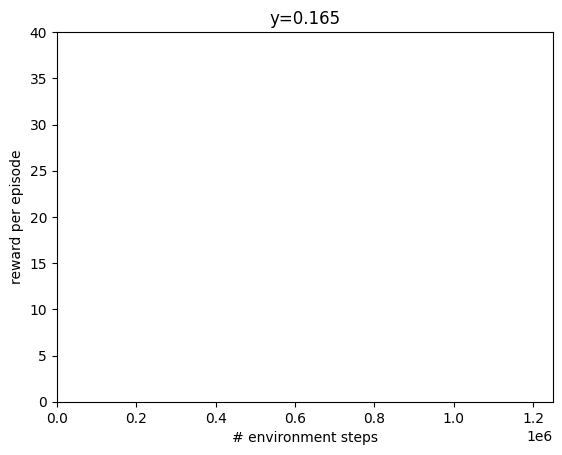

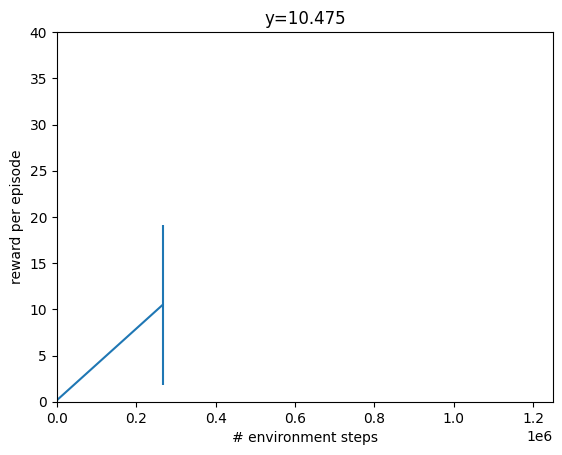

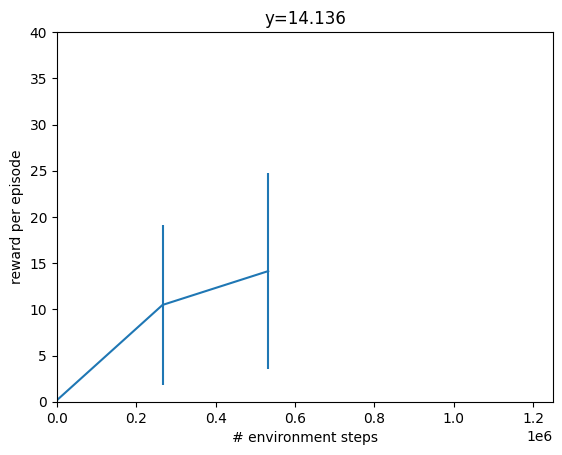

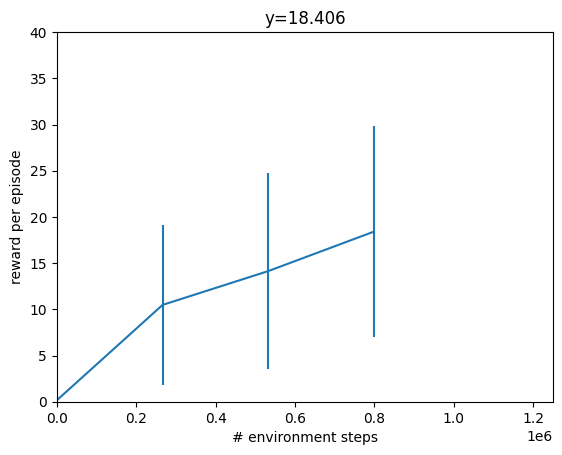

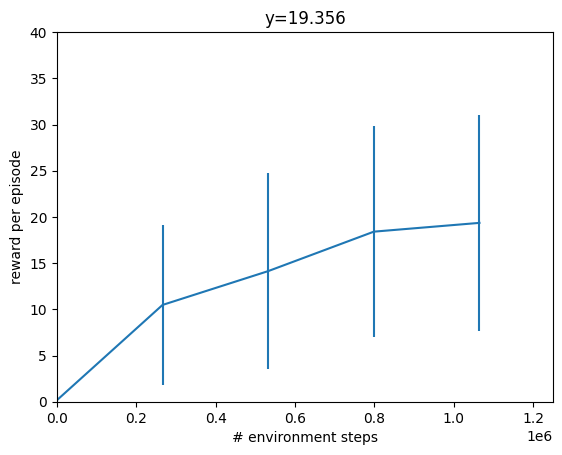

time to jit: 0:02:01.439327
time to train: 0:03:26.616924
Trained policy saved to experiments/trained_policies/my_experiment


In [12]:
# @title Sequentially run training for all configurations
from quadruped_mjx_rl.config_utils import prepare_configs
from quadruped_mjx_rl.training import train
from quadruped_mjx_rl import environments
from quadruped_mjx_rl.environments import get_env_factory

# @markdown Choose with which configs to train
training_runs = None # @param {"type":"raw","placeholder":"[\"experiment_name1\", \"experiment_name2\", ... ]"}
# @markdown or
run_them_all = True # @param {"type":"boolean"}
if run_them_all:
    training_runs = [
        config_file.stem
        for config_file in configs_dir.iterdir() if config_file.name.endswith(".yaml")
    ]


for experiment_name in training_runs:
    config_path = configs_dir / f"{experiment_name}.yaml"
    configs = prepare_configs(config_path)
    environment_config = configs["environment"]
    robot_config = configs["robot"]
    model_config = configs["model"]
    training_config = configs["training"]
    vision_config = configs.get("vision")

    if isinstance(environment_config, environments.QuadrupedVisionEnvConfig):
        scene_file = "scene_mjx_vision.xml"
    else:
        scene_file = "scene_mjx.xml"
    init_scene_path = repo_path / "resources" / robot_config.robot_name / scene_file

    env_factory, uses_vision = get_env_factory(
        env_config=environment_config,
        robot_config=robot_config,
        init_scene_path=init_scene_path,
    )

    trained_policy_save_path = trained_policy_dir / f"{experiment_name}"

    print(f"Starting training for: {experiment_name}")
    train(
        env_factory=env_factory,
        model_config=model_config,
        training_config=training_config,
        model_save_path=trained_policy_save_path,
        checkpoints_save_path=None, #TODO: enable
        vision=uses_vision,
        vision_config=vision_config,
    )
    print(f"Trained policy saved to {trained_policy_save_path}")

# Results
This section can be run independently from the training section, including after restarts and crashes. As long as all the created files remain in the session's disk memory.

In [13]:
#@title List all configured experiments
!ls {configs_dir}

my_experiment.yaml  rollout_configs


In [15]:
# @title Configure a rollout for rendering
from quadruped_mjx_rl.config_utils import save_configs
from quadruped_mjx_rl.policy_rendering import RenderConfig

experiment_name = "my_experiment"  #@param {type:"string"}
rollout_name = "my_rollout" # @param {type:"string"}

n_steps = 500 # @param {"type":"integer"}
render_every = 2 # @param {"type":"integer"}
random_seed = 0 # @param {"type":"integer"}

# @markdown ---
# @markdown Joystick command for the robot to follow (in SI)
x_vel = 1.0 # @param {"type":"number"}
y_vel = 0.0 # @param {"type":"number"}
ang_vel = 0.0 # @param {"type":"number"}

render_config = RenderConfig(
    n_steps=n_steps,
    episode_length=n_steps * 2,
    render_every=render_every,
    seed=random_seed,
    command={
        "x_vel": x_vel,
        "y_vel": y_vel,
        "ang_vel": ang_vel,
    },
)

config_file_path = rollout_configs_dir / f"{experiment_name}_rendering_{rollout_name}.yaml"
save_configs(config_file_path, render_config)
print(f"Rollout configs saved to {config_file_path}")

Rollout configs saved to experiments/configs/rollout_configs/my_experiment_rendering_my_rollout.yaml


In [18]:
# @title Render all configured policy rollouts
from quadruped_mjx_rl.policy_rendering import render_policy_rollout
from quadruped_mjx_rl import environments
from quadruped_mjx_rl.environments import get_env_factory
from quadruped_mjx_rl.config_utils import prepare_configs

# @markdown All rollouts present will be rendered
delete_rollouts_after_rendering = True # @param {"type":"boolean"}
save_rollout_gifs = True # @param {"type":"boolean"}

for experiment_config_file in configs_dir.iterdir():
    if not experiment_config_file.name.endswith(".yaml"):
        continue
    experiment_name = experiment_config_file.stem
    configs = prepare_configs(experiment_config_file)
    environment_config = configs["environment"]
    robot_config = configs["robot"]
    model_config = configs["model"]
    vision_config = configs.get("vision")

    init_scene_path = repo_path / "resources" / robot_config.robot_name / "scene_mjx.xml"

    env_factory, vision = get_env_factory(
        env_config=environment_config,
        robot_config=robot_config,
        init_scene_path=init_scene_path,
    )

    trained_policy = trained_policy_dir / f"{experiment_name}"

    rollout_configs_list = []
    for rollout_config_file in rollout_configs_dir.iterdir():
        if (
            not rollout_config_file.name.endswith(".yaml")
            or "_rendering_" not in rollout_config_file.name
            or experiment_name != rollout_config_file.name.split("_rendering_")[0]
        ):
            continue
        rollout_configs_list.append(rollout_config_file)

        render_config = prepare_configs(rollout_config_file)["render"]

        if save_rollout_gifs:
            animation_save_path = animations_dir / f"{rollout_config_file.stem}.gif"
        else:
            animation_save_path = None

        render_policy_rollout(
            env_factory=env_factory,
            model_config=model_config,
            trained_model_path=trained_policy,
            render_config=render_config,
            animation_save_path=animation_save_path,
            vision=vision,
        )

    if delete_rollouts_after_rendering:
        for rollout_config_file in rollout_configs_list:
            rollout_config_file.unlink()

/usr/local/lib/python3.11/dist-packages/brax/io/mjcf.py:480: UserWarning: Brax System, piplines and environments are not actively being maintained. Please see MJX for a well maintained JAX-based physics engine: https://github.com/google-deepmind/mujoco/tree/main/mjx. For a host of environments that use MJX, see: https://github.com/google-deepmind/mujoco_playground.
  warnings.warn(


In [19]:
# @title Saving results
from google.colab import files, drive
from etils.epath import Path

# @markdown (This can be run in a separate session)

# @markdown Choose what you want to save
policies = True # @param {"type":"boolean"}
rollout_gifs = True # @param {"type":"boolean"}
config_files = True # @param {"type":"boolean"}
# @markdown Only the configs for the training are saved

# @markdown Choose whether you want to download your results
download_results = False # @ param {"type":"boolean"}

# @markdown Choose whether you want to save results to your Google drive
save_to_drive = True # @param {"type":"boolean"}
drive_save_folder = "quadruped_mjx_rl_Results" # @param {type:"string"}
if save_to_drive:
    drive.mount('/content/drive')

for do_save, directory in zip(
    [policies, rollout_gifs, config_files], [trained_policy_dir, animations_dir, configs_dir],
):
    if not do_save:
        continue
    for file_path in directory.iterdir():
        if file_path.is_dir():
            continue
        if download_results:
            files.download(file_path)
        if save_to_drive:
            drive_dir = Path(f"/content/drive/MyDrive/{drive_save_folder}/{directory.name}")
            drive_dir.mkdir(parents=True, exist_ok=True)
            file_path.copy(
                dst=drive_dir / file_path.name, overwrite=True
            )

if save_to_drive:
    drive.flush_and_unmount()

Mounted at /content/drive
